In [27]:
!pip install pyspark --quiet
!pip install findspark --quiet

In [28]:
import pyspark
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import lit, desc, asc, round

In [29]:
spark = SparkSession.builder.appName('tech_challenge').getOrCreate()

In [30]:
# df = spark.read.csv('PNAD_112020.csv', sep=',')

In [31]:
# df.createOrReplaceTempView('pnad')

In [32]:
# dfTest = spark.sql("SELECT COUNT(*) from pnad")
# dfTest

In [33]:
# pd_df = pd.read_csv('PNAD_COVID_112020.csv')

In [34]:
# pd_df['B005'].isnull().sum()

In [35]:
interested_columns = [
    'Ano',
    'UF',
    'CAPITAL',
    'RM_RIDE',
    'V1008',
    'V1012',
    'V1013',
    'V1016',
    'Estrato',
    'UPA',
    'V1022',
    'V1023',
    'V1030',
    'V1031',
    'V1032',
    'posest',
    'B0011',
    'B0012',
    'B0014',
    'B002',
    'B0031',
    'B0042',
    'B005',
    'B0033',
    'C001',
    'C002',
    'C013',
    'C014',
    'C015',
    'C016',
    'D0051',
    'D0041',
    'D0021',
    'D0071',
    'D0061',
    'D0031',
    'D0011'
]

In [36]:
# pd_df = pd_df[interested_columns]

In [37]:
# pd_df.columns

In [38]:
# pd_df.to_csv('PNAD_112020_RECORTE.csv')

In [39]:
pnad_spark = spark.read.csv('PNAD_112020_RECORTE.csv', header=True, inferSchema=True)

pnad_spark.show()

+---+----+---+-------+-------+-----+-----+-----+-----+-------+---------+-----+-----+------+------------+------------+------+-----+-----+-----+----+-----+-----+----+-----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+
|_c0| Ano| UF|CAPITAL|RM_RIDE|V1008|V1012|V1013|V1016|Estrato|      UPA|V1022|V1023| V1030|       V1031|       V1032|posest|B0011|B0012|B0014|B002|B0031|B0042|B005|B0033|C001|C002|C013|C014|C015|C016|D0051|D0041|D0021|D0071|D0061|D0031|D0011|
+---+----+---+-------+-------+-----+-----+-----+-----+-------+---------+-----+-----+------+------------+------------+------+-----+-----+-----+----+-----+-----+----+-----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+
|  0|2020| 11|   11.0|   NULL|    1|    4|   11|    7|1110011|110015970|    1|    1|152902|101.01170275|117.46371855|  1114|    2|    2|    2|NULL| NULL| NULL|NULL| NULL| 1.0|NULL|NULL|NULL|NULL|NULL|    1|    2|    2|    2|    2|    2|    2|
|  1|2020| 11|   11.0|   NUL

In [40]:
pnad_spark.createOrReplaceTempView('pnad')

# Parte B - COVID19 - Todos os moradores

In [41]:
defaultAnswers = {
    1: 'Sim',
    2: 'Não',
    3: 'Não Sabe',
    9: 'Ignorado',
}

def selectByVarCode(cod, answers = defaultAnswers):
  cases = ['CASE']

  for x in answers:
    cases.append(f"WHEN {cod} = '{x}' THEN '{answers[x]}'")

  return spark.sql(f"SELECT UF, {' '.join(cases)} ELSE 'Não aplicável' END as answer FROM pnad")

In [42]:
def summary(df):
  print(f"""
+-------------+------+
   Answers: {df.count()}
+-------------+------+
  """)

  df.groupBy('answer').count().show()

  symptons_by_state = df.groupBy("UF").count().withColumnRenamed('count', 'total')
  symptons_by_state = symptons_by_state.join(
      df.filter(df.answer == 'Sim').groupBy('UF').count().withColumnRenamed('count', 'positives'),
      "UF",
      "INNER"
  )

  symptons_by_state.select(
      symptons_by_state.UF,
      symptons_by_state.total,
      symptons_by_state.positives,
      (round((symptons_by_state.positives / symptons_by_state.total) * 100, 2)).alias('(%)'),
  ).sort(desc('(%)')).show(27)

## B1.B0011 - Na semana passada teve febre?

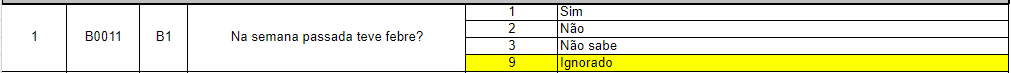

In [43]:
df_b0011 = selectByVarCode('B0011')
summary(df_b0011)


+-------------+------+
   Answers: 381438
+-------------+------+
  
+--------+------+
|  answer| count|
+--------+------+
|Ignorado|   984|
|     Não|377080|
|     Sim|  3168|
|Não Sabe|   206|
+--------+------+

+---+-----+---------+----+
| UF|total|positives| (%)|
+---+-----+---------+----+
| 16| 2472|       55|2.22|
| 15|11878|      150|1.26|
| 14| 5614|       64|1.14|
| 21|20404|      220|1.08|
| 13|10341|      111|1.07|
| 41|19872|      186|0.94|
| 52|14195|      132|0.93|
| 26|17138|      157|0.92|
| 24| 7775|       70| 0.9|
| 32|15863|      142| 0.9|
| 42|23432|      210| 0.9|
| 50| 8657|       77|0.89|
| 43|21931|      193|0.88|
| 17| 5087|       43|0.85|
| 12| 6102|       49| 0.8|
| 51|11359|       91| 0.8|
| 53| 6795|       51|0.75|
| 31|34339|      254|0.74|
| 22| 8480|       61|0.72|
| 11| 6001|       43|0.72|
| 25| 9873|       68|0.69|
| 35|32104|      223|0.69|
| 33|29065|      202|0.69|
| 29|17063|      116|0.68|
| 28| 8013|       48| 0.6|
| 23|16182|       91|0.56|
| 2

## B1.B0012 Na semana passada teve tosse?

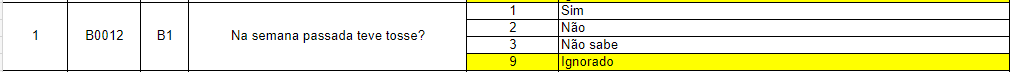

In [44]:
df_b0012 = selectByVarCode('B0012')
summary(df_b0012)


+-------------+------+
   Answers: 381438
+-------------+------+
  
+--------+------+
|  answer| count|
+--------+------+
|Ignorado|   988|
|     Não|374980|
|     Sim|  5259|
|Não Sabe|   211|
+--------+------+

+---+-----+---------+----+
| UF|total|positives| (%)|
+---+-----+---------+----+
| 16| 2472|       56|2.27|
| 31|34339|      590|1.72|
| 43|21931|      375|1.71|
| 25| 9873|      163|1.65|
| 52|14195|      231|1.63|
| 41|19872|      324|1.63|
| 15|11878|      192|1.62|
| 21|20404|      331|1.62|
| 32|15863|      255|1.61|
| 50| 8657|      122|1.41|
| 42|23432|      325|1.39|
| 26|17138|      234|1.37|
| 53| 6795|       91|1.34|
| 24| 7775|      102|1.31|
| 13|10341|      134| 1.3|
| 35|32104|      415|1.29|
| 17| 5087|       64|1.26|
| 29|17063|      212|1.24|
| 11| 6001|       71|1.18|
| 14| 5614|       65|1.16|
| 33|29065|      336|1.16|
| 51|11359|      124|1.09|
| 22| 8480|       89|1.05|
| 28| 8013|       74|0.92|
| 23|16182|      148|0.91|
| 27|11403|       94|0.82|
| 1

## B1.B0014 Na semana passada teve dificuldade para respirar?

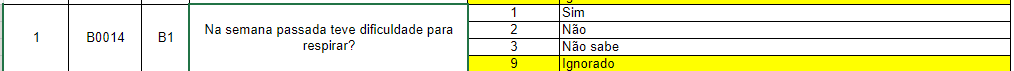

In [45]:
df_b0014 = selectByVarCode('B0014')

summary(df_b0014)


+-------------+------+
   Answers: 381438
+-------------+------+
  
+--------+------+
|  answer| count|
+--------+------+
|Ignorado|   989|
|     Não|378697|
|     Sim|  1538|
|Não Sabe|   214|
+--------+------+

+---+-----+---------+----+
| UF|total|positives| (%)|
+---+-----+---------+----+
| 16| 2472|       22|0.89|
| 43|21931|      128|0.58|
| 41|19872|      108|0.54|
| 31|34339|      172| 0.5|
| 11| 6001|       29|0.48|
| 52|14195|       68|0.48|
| 35|32104|      151|0.47|
| 50| 8657|       41|0.47|
| 14| 5614|       26|0.46|
| 32|15863|       72|0.45|
| 42|23432|      103|0.44|
| 26|17138|       74|0.43|
| 15|11878|       48| 0.4|
| 13|10341|       38|0.37|
| 17| 5087|       18|0.35|
| 33|29065|       98|0.34|
| 24| 7775|       25|0.32|
| 51|11359|       35|0.31|
| 29|17063|       52| 0.3|
| 12| 6102|       18|0.29|
| 22| 8480|       24|0.28|
| 23|16182|       43|0.27|
| 21|20404|       56|0.27|
| 28| 8013|       21|0.26|
| 53| 6795|       18|0.26|
| 27|11403|       28|0.25|
| 2

## B2.B002 - Por causa disso, foi a algum estabelecimento de saúde?

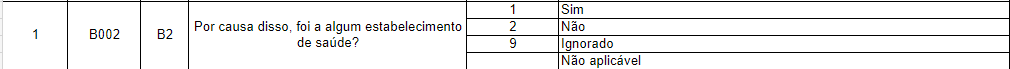

In [46]:
df_b002 = selectByVarCode('B002')
summary(df_b002)


+-------------+------+
   Answers: 381438
+-------------+------+
  
+-------------+------+
|       answer| count|
+-------------+------+
|     Ignorado|     5|
|          Não| 10096|
|          Sim|  4029|
|Não aplicável|367308|
+-------------+------+

+---+-----+---------+----+
| UF|total|positives| (%)|
+---+-----+---------+----+
| 16| 2472|       48|1.94|
| 41|19872|      292|1.47|
| 43|21931|      319|1.45|
| 42|23432|      316|1.35|
| 32|15863|      210|1.32|
| 50| 8657|      109|1.26|
| 52|14195|      178|1.25|
| 31|34339|      420|1.22|
| 25| 9873|      118| 1.2|
| 35|32104|      343|1.07|
| 51|11359|      122|1.07|
| 15|11878|      120|1.01|
| 17| 5087|       51| 1.0|
| 24| 7775|       76|0.98|
| 11| 6001|       58|0.97|
| 53| 6795|       65|0.96|
| 29|17063|      153| 0.9|
| 26|17138|      151|0.88|
| 33|29065|      253|0.87|
| 13|10341|       87|0.84|
| 14| 5614|       46|0.82|
| 21|20404|      156|0.76|
| 22| 8480|       64|0.75|
| 23|16182|      113| 0.7|
| 12| 6102|      

## B3.B0031 - Providência tomada para recuperar dos sintomas foi ficar em casa

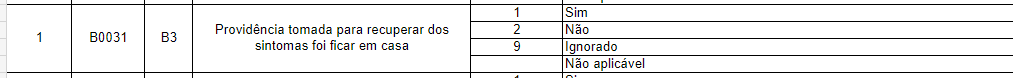

In [47]:
df_b0031 = selectByVarCode('B0031')
summary(df_b0031)


+-------------+------+
   Answers: 381438
+-------------+------+
  
+-------------+------+
|       answer| count|
+-------------+------+
|     Ignorado|    29|
|          Não|  2628|
|          Sim|  7439|
|Não aplicável|371342|
+-------------+------+

+---+-----+---------+----+
| UF|total|positives| (%)|
+---+-----+---------+----+
| 16| 2472|      102|4.13|
| 21|20404|      666|3.26|
| 25| 9873|      286| 2.9|
| 29|17063|      445|2.61|
| 15|11878|      290|2.44|
| 31|34339|      835|2.43|
| 24| 7775|      185|2.38|
| 22| 8480|      191|2.25|
| 43|21931|      455|2.07|
| 17| 5087|      105|2.06|
| 23|16182|      332|2.05|
| 26|17138|      338|1.97|
| 52|14195|      280|1.97|
| 35|32104|      630|1.96|
| 28| 8013|      153|1.91|
| 41|19872|      362|1.82|
| 12| 6102|      106|1.74|
| 53| 6795|      118|1.74|
| 27|11403|      192|1.68|
| 13|10341|      172|1.66|
| 14| 5614|       92|1.64|
| 32|15863|      237|1.49|
| 11| 6001|       84| 1.4|
| 51|11359|      140|1.23|
| 33|29065|      

## B3.B0033 - Providência tomada  para recuperar dos sintomas foi comprar e/ou tomar  remédio por conta própria

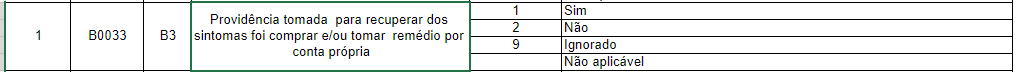

In [48]:
df_b0033 = selectByVarCode('B0033')
summary(df_b0033)


+-------------+------+
   Answers: 381438
+-------------+------+
  
+-------------+------+
|       answer| count|
+-------------+------+
|     Ignorado|    15|
|          Não|  3613|
|          Sim|  6468|
|Não aplicável|371342|
+-------------+------+

+---+-----+---------+----+
| UF|total|positives| (%)|
+---+-----+---------+----+
| 16| 2472|       80|3.24|
| 21|20404|      618|3.03|
| 29|17063|      399|2.34|
| 15|11878|      274|2.31|
| 25| 9873|      219|2.22|
| 31|34339|      758|2.21|
| 28| 8013|      157|1.96|
| 52|14195|      274|1.93|
| 24| 7775|      148| 1.9|
| 22| 8480|      160|1.89|
| 43|21931|      410|1.87|
| 26|17138|      315|1.84|
| 17| 5087|       86|1.69|
| 23|16182|      269|1.66|
| 35|32104|      484|1.51|
| 13|10341|      155| 1.5|
| 53| 6795|      100|1.47|
| 12| 6102|       89|1.46|
| 14| 5614|       82|1.46|
| 51|11359|      166|1.46|
| 32|15863|      221|1.39|
| 41|19872|      256|1.29|
| 27|11403|      137| 1.2|
| 11| 6001|       69|1.15|
| 50| 8657|      

## B4.B0042 - Local que buscou atendimento foi pronto socorro do SUS/UPA

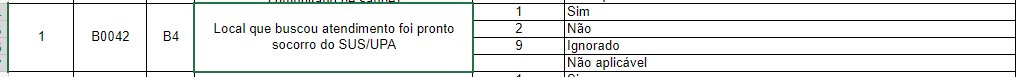

In [49]:
df_b0042 = selectByVarCode('B0042')
summary(df_b0042)


+-------------+------+
   Answers: 381438
+-------------+------+
  
+-------------+------+
|       answer| count|
+-------------+------+
|     Ignorado|    29|
|          Não|  3136|
|          Sim|   864|
|Não aplicável|377409|
+-------------+------+

+---+-----+---------+----+
| UF|total|positives| (%)|
+---+-----+---------+----+
| 32|15863|       61|0.38|
| 11| 6001|       21|0.35|
| 16| 2472|        8|0.32|
| 15|11878|       38|0.32|
| 35|32104|      103|0.32|
| 42|23432|       76|0.32|
| 41|19872|       62|0.31|
| 51|11359|       35|0.31|
| 13|10341|       28|0.27|
| 52|14195|       35|0.25|
| 43|21931|       54|0.25|
| 31|34339|       74|0.22|
| 50| 8657|       19|0.22|
| 33|29065|       63|0.22|
| 26|17138|       35| 0.2|
| 24| 7775|       13|0.17|
| 12| 6102|       10|0.16|
| 25| 9873|       15|0.15|
| 23|16182|       21|0.13|
| 29|17063|       22|0.13|
| 21|20404|       26|0.13|
| 22| 8480|       10|0.12|
| 14| 5614|        7|0.12|
| 53| 6795|        8|0.12|
| 28| 8013|      

## B5.B005 - Ao procurar o hospital, teve que ficar internado por um dia ou mais

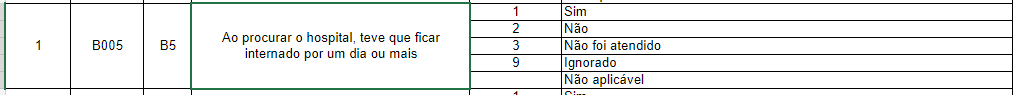

In [50]:
cod = 'B005'

answers = {
    1: 'Sim',
    2: 'Não',
    3: 'Não foi atendido',
    9: 'Ignorado',
}

df_b005 = selectByVarCode(cod, answers)
summary(df_b005)


+-------------+------+
   Answers: 381438
+-------------+------+
  
+----------------+------+
|          answer| count|
+----------------+------+
|             Não|  1873|
|Não foi atendido|    25|
|             Sim|   198|
|   Não aplicável|379339|
|        Ignorado|     3|
+----------------+------+

+---+-----+---------+----+
| UF|total|positives| (%)|
+---+-----+---------+----+
| 51|11359|       11| 0.1|
| 26|17138|       14|0.08|
| 52|14195|       12|0.08|
| 43|21931|       17|0.08|
| 50| 8657|        7|0.08|
| 15|11878|        8|0.07|
| 21|20404|       14|0.07|
| 32|15863|       11|0.07|
| 23|16182|       10|0.06|
| 53| 6795|        4|0.06|
| 35|32104|       19|0.06|
| 31|34339|       18|0.05|
| 12| 6102|        3|0.05|
| 11| 6001|        3|0.05|
| 42|23432|       11|0.05|
| 28| 8013|        3|0.04|
| 27|11403|        5|0.04|
| 16| 2472|        1|0.04|
| 17| 5087|        2|0.04|
| 41|19872|        8|0.04|
| 24| 7775|        2|0.03|
| 13|10341|        2|0.02|
| 25| 9873|        2|

# Parte C - Características de trabalho das pessoas de 14 anos ou mais de idade

## C1.C001 - Na semana passada, por pelo menos uma hora, trabalhou ou fez algum bico?

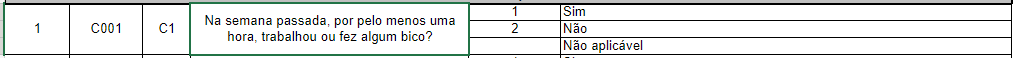

In [51]:
df_c001 = selectByVarCode('C001')
summary(df_c001)


+-------------+------+
   Answers: 381438
+-------------+------+
  
+-------------+------+
|       answer| count|
+-------------+------+
|          Não|172474|
|          Sim|142670|
|Não aplicável| 66294|
+-------------+------+

+---+-----+---------+-----+
| UF|total|positives|  (%)|
+---+-----+---------+-----+
| 43|21931|     9935| 45.3|
| 42|23432|    10381| 44.3|
| 41|19872|     8754|44.05|
| 50| 8657|     3717|42.94|
| 51|11359|     4859|42.78|
| 52|14195|     6039|42.54|
| 35|32104|    13359|41.61|
| 11| 6001|     2468|41.13|
| 32|15863|     6491|40.92|
| 31|34339|    13628|39.69|
| 53| 6795|     2681|39.46|
| 17| 5087|     1920|37.74|
| 33|29065|    10058|34.61|
| 15|11878|     4078|34.33|
| 22| 8480|     2893|34.12|
| 29|17063|     5779|33.87|
| 13|10341|     3496|33.81|
| 26|17138|     5569| 32.5|
| 23|16182|     5225|32.29|
| 24| 7775|     2457| 31.6|
| 14| 5614|     1757| 31.3|
| 28| 8013|     2497|31.16|
| 12| 6102|     1901|31.15|
| 25| 9873|     3053|30.92|
| 16| 2472|  

## C2.C002 - Na semana passada, estava temporariamente afastado de algum trabalho?

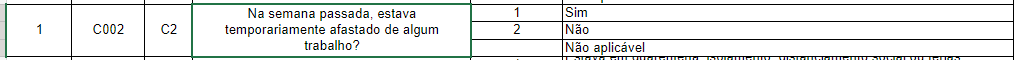

In [52]:
df_c002 = selectByVarCode('C002')
summary(df_c002)


+-------------+------+
   Answers: 381438
+-------------+------+
  
+-------------+------+
|       answer| count|
+-------------+------+
|          Não|160039|
|          Sim| 12435|
|Não aplicável|208964|
+-------------+------+

+---+-----+---------+----+
| UF|total|positives| (%)|
+---+-----+---------+----+
| 33|29065|     1495|5.14|
| 16| 2472|      126| 5.1|
| 12| 6102|      260|4.26|
| 14| 5614|      233|4.15|
| 29|17063|      629|3.69|
| 24| 7775|      286|3.68|
| 53| 6795|      247|3.64|
| 26|17138|      598|3.49|
| 32|15863|      554|3.49|
| 43|21931|      742|3.38|
| 13|10341|      333|3.22|
| 42|23432|      737|3.15|
| 31|34339|     1075|3.13|
| 23|16182|      500|3.09|
| 52|14195|      438|3.09|
| 15|11878|      365|3.07|
| 25| 9873|      297|3.01|
| 22| 8480|      252|2.97|
| 17| 5087|      151|2.97|
| 35|32104|      951|2.96|
| 41|19872|      573|2.88|
| 11| 6001|      172|2.87|
| 51|11359|      318| 2.8|
| 27|11403|      296| 2.6|
| 50| 8657|      197|2.28|
| 28| 8013|  

## C13.C013 - Na semana passada, o(a) Sr(a) estava em trabalho remoto (home office ou teletrabalho)?

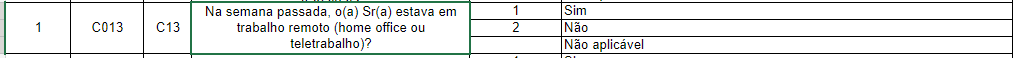

In [53]:
df_c013 = selectByVarCode('C013')
summary(df_c013)


+-------------+------+
   Answers: 381438
+-------------+------+
  
+-------------+------+
|       answer| count|
+-------------+------+
|          Não|  4818|
|          Sim| 10863|
|Não aplicável|365757|
+-------------+------+

+---+-----+---------+----+
| UF|total|positives| (%)|
+---+-----+---------+----+
| 53| 6795|      518|7.62|
| 33|29065|     1502|5.17|
| 35|32104|     1489|4.64|
| 41|19872|      766|3.85|
| 43|21931|      753|3.43|
| 42|23432|      757|3.23|
| 25| 9873|      302|3.06|
| 52|14195|      386|2.72|
| 31|34339|      906|2.64|
| 32|15863|      416|2.62|
| 16| 2472|       61|2.47|
| 11| 6001|      145|2.42|
| 28| 8013|      190|2.37|
| 26|17138|      377| 2.2|
| 22| 8480|      182|2.15|
| 17| 5087|      108|2.12|
| 23|16182|      331|2.05|
| 50| 8657|      166|1.92|
| 24| 7775|      146|1.88|
| 14| 5614|      104|1.85|
| 12| 6102|      109|1.79|
| 51|11359|      185|1.63|
| 29|17063|      274|1.61|
| 27|11403|      169|1.48|
| 13|10341|      133|1.29|
| 21|20404|  

## C14.C014 - O(A) Sr(a) contribui para o INSS?  

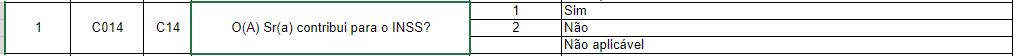

In [54]:
df_c014 = selectByVarCode('C014')
summary(df_c014)


+-------------+------+
   Answers: 381438
+-------------+------+
  
+-------------+------+
|       answer| count|
+-------------+------+
|          Não|208368|
|          Sim| 37670|
|Não aplicável|135400|
+-------------+------+

+---+-----+---------+-----+
| UF|total|positives|  (%)|
+---+-----+---------+-----+
| 42|23432|     4052|17.29|
| 43|21931|     3535|16.12|
| 41|19872|     2941| 14.8|
| 32|15863|     1910|12.04|
| 31|34339|     3630|10.57|
| 53| 6795|      715|10.52|
| 51|11359|     1192|10.49|
| 35|32104|     3328|10.37|
| 33|29065|     2937| 10.1|
| 11| 6001|      598| 9.97|
| 52|14195|     1333| 9.39|
| 50| 8657|      755| 8.72|
| 17| 5087|      440| 8.65|
| 21|20404|     1562| 7.66|
| 25| 9873|      735| 7.44|
| 24| 7775|      570| 7.33|
| 29|17063|     1244| 7.29|
| 13|10341|      745|  7.2|
| 22| 8480|      585|  6.9|
| 27|11403|      785| 6.88|
| 15|11878|      803| 6.76|
| 26|17138|     1065| 6.21|
| 23|16182|     1005| 6.21|
| 14| 5614|      329| 5.86|
| 28| 8013|  

## C15.C015 - Na semana passada ___ tomou alguma providência efetiva para conseguir trabalho?  

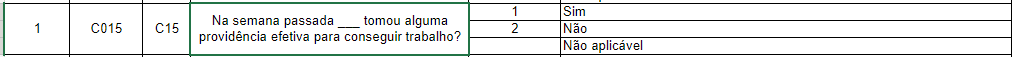

In [55]:
df_c015 = selectByVarCode('C015')
summary(df_c015)


+-------------+------+
   Answers: 381438
+-------------+------+
  
+-------------+------+
|       answer| count|
+-------------+------+
|          Não|146983|
|          Sim| 22368|
|Não aplicável|212087|
+-------------+------+

+---+-----+---------+----+
| UF|total|positives| (%)|
+---+-----+---------+----+
| 16| 2472|      220| 8.9|
| 29|17063|     1418|8.31|
| 53| 6795|      535|7.87|
| 13|10341|      767|7.42|
| 26|17138|     1252|7.31|
| 28| 8013|      584|7.29|
| 33|29065|     2041|7.02|
| 21|20404|     1405|6.89|
| 35|32104|     2138|6.66|
| 24| 7775|      497|6.39|
| 15|11878|      735|6.19|
| 32|15863|      960|6.05|
| 52|14195|      844|5.95|
| 31|34339|     1989|5.79|
| 14| 5614|      317|5.65|
| 25| 9873|      548|5.55|
| 50| 8657|      437|5.05|
| 12| 6102|      307|5.03|
| 27|11403|      568|4.98|
| 17| 5087|      252|4.95|
| 51|11359|      547|4.82|
| 41|19872|      954| 4.8|
| 23|16182|      745| 4.6|
| 11| 6001|      256|4.27|
| 43|21931|      895|4.08|
| 42|23432|  

## C16.C016 - Qual o principal motivo de não ter procurado trabalho na semana passada?

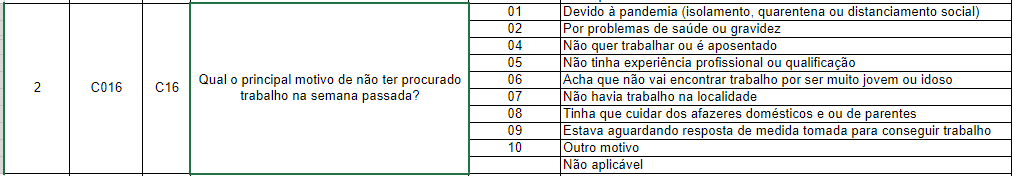

In [64]:
answers = {
    1: 'Devido à pandemia (isolamento, quarentena ou distanciamento social)',
    2: 'Por problemas de saúde ou gravidez',
    4: 'Não quer trabalhar ou é aposentado',
    5: 'Não tinha experiência profissional ou qualificação',
    6: 'Acha que não vai encontrar trabalho por ser muito jovem ou idoso',
    7: 'Não havia trabalho na localidade',
    8: 'Tinha que cuidar dos afazeres domésticos e ou de parentes',
    9: 'Estava aguardando resposta de medida tomada para conseguir trabalho',
    10: 'Outro motivo'
}

df_c016 = selectByVarCode('C016', answers)
# summary(df_c016)

In [70]:
print(f"""
+-------------+------+
   Answers: {df_c016.count()}
+-------------+------+
  """)

df_c016.groupBy('answer').count().show()

print("""
+--------------------+------++--------------------+------++--------------------+------+---+----+
|                                          dicionario                                          |
+--------------------+------++--------------------+------++--------------------+------+---+----+
| Devido à pandemia (isolamento quarentena ou distanciamento social)   | pandemic              |
|----------------------------------------------------------------------|-----------------------|
| Por problemas de saúde ou gravidez                                   | health_or_pregnancy   |
|----------------------------------------------------------------------|-----------------------|
| Não quer trabalhar ou é aposentado                                   | retired               |
|----------------------------------------------------------------------|-----------------------|
| Não tinha experiência profissional ou qualificação                   | inexperience          |
|----------------------------------------------------------------------|-----------------------|
| Acha que não vai encontrar trabalho por ser muito jovem ou idoso     | age_insecurity        |
|----------------------------------------------------------------------|-----------------------|
| Não havia trabalho na localidade                                     | without_jobs_nearby   |
|----------------------------------------------------------------------|-----------------------|
| Tinha que cuidar dos afazeres domésticos e ou de parentes            | personal_reasons      |
|----------------------------------------------------------------------|-----------------------|
| Estava aguardando resposta de medida tomada para conseguir trabalho  | waiting_job_reply     |
|----------------------------------------------------------------------|-----------------------|
| Outro motivo                                                         | others                |
+--------------------+------+--------------------+------+--------------+-----------+-----------+
""")

work_data_by_state = df_c016.groupBy("UF").count().withColumnRenamed('count', 'total')
work_data_by_state = work_data_by_state.join(
    df_c016.filter(df_c016.answer == 'Devido à pandemia (isolamento, quarentena ou distanciamento social)').groupBy('UF').count().withColumnRenamed('count', 'pandemic'),
    "UF",
    "INNER"
)

work_data_by_state = work_data_by_state.join(
    df_c016.filter(df_c016.answer == 'Por problemas de saúde ou gravidez').groupBy('UF').count().withColumnRenamed('count', 'health_or_pregnancy'),
    "UF",
    "INNER"
)

work_data_by_state = work_data_by_state.join(
    df_c016.filter(df_c016.answer == 'Não quer trabalhar ou é aposentado').groupBy('UF').count().withColumnRenamed('count', 'retired'),
    "UF",
    "INNER"
)

work_data_by_state = work_data_by_state.join(
    df_c016.filter(df_c016.answer == 'Não tinha experiência profissional ou qualificação').groupBy('UF').count().withColumnRenamed('count', 'inexperience'),
    "UF",
    "INNER"
)

work_data_by_state = work_data_by_state.join(
    df_c016.filter(df_c016.answer == 'Acha que não vai encontrar trabalho por ser muito jovem ou idoso').groupBy('UF').count().withColumnRenamed('count', 'age_insecurity'),
    "UF",
    "INNER"
)

work_data_by_state = work_data_by_state.join(
    df_c016.filter(df_c016.answer == 'Não havia trabalho na localidade').groupBy('UF').count().withColumnRenamed('count', 'without_jobs_nearby'),
    "UF",
    "INNER"
)

work_data_by_state = work_data_by_state.join(
    df_c016.filter(df_c016.answer == 'Tinha que cuidar dos afazeres domésticos e ou de parentes').groupBy('UF').count().withColumnRenamed('count', 'personal_reasons'),
    "UF",
    "INNER"
)

work_data_by_state = work_data_by_state.join(
    df_c016.filter(df_c016.answer == 'Estava aguardando resposta de medida tomada para conseguir trabalho').groupBy('UF').count().withColumnRenamed('count', 'waiting_job_reply'),
    "UF",
    "INNER"
)

work_data_by_state = work_data_by_state.join(
    df_c016.filter(df_c016.answer == 'Outro motivo').groupBy('UF').count().withColumnRenamed('count', 'others'),
    "UF",
    "INNER"
)

work_data_by_state.select(
    work_data_by_state.UF,
    work_data_by_state.total,
    work_data_by_state.pandemic,
    (round((work_data_by_state.pandemic / work_data_by_state.total) * 100, 2)).alias('pandemic(%)'),
    work_data_by_state.health_or_pregnancy,
    (round((work_data_by_state.health_or_pregnancy / work_data_by_state.total) * 100, 2)).alias('health_or_pregnancy(%)'),
    work_data_by_state.retired,
    (round((work_data_by_state.retired / work_data_by_state.total) * 100, 2)).alias('retired(%)'),
).sort(desc('total')).show(27)

work_data_by_state.select(
    work_data_by_state.UF,
    work_data_by_state.total,
    work_data_by_state.inexperience,
    (round((work_data_by_state.inexperience / work_data_by_state.total) * 100, 2)).alias('inexperience(%)'),
    work_data_by_state.age_insecurity,
    (round((work_data_by_state.age_insecurity / work_data_by_state.total) * 100, 2)).alias('age_insecurity(%)'),
    work_data_by_state.without_jobs_nearby,
    (round((work_data_by_state.without_jobs_nearby / work_data_by_state.total) * 100, 2)).alias('without_jobs_nearby(%)'),
    work_data_by_state.personal_reasons,
    (round((work_data_by_state.personal_reasons / work_data_by_state.total) * 100, 2)).alias('personal_reasons(%)'),
    work_data_by_state.waiting_job_reply,
    (round((work_data_by_state.waiting_job_reply / work_data_by_state.total) * 100, 2)).alias('waiting_job_reply(%)'),
    work_data_by_state.others,
    (round((work_data_by_state.others / work_data_by_state.total) * 100, 2)).alias('others(%)'),
).sort(desc('total')).show(27)


+-------------+------+
   Answers: 381438
+-------------+------+
  
+--------------------+------+
|              answer| count|
+--------------------+------+
|Não tinha experiê...|   680|
|Devido à pandemia...| 22109|
|Estava aguardando...|   805|
|Acha que não vai ...|  2191|
|Tinha que cuidar ...| 20310|
|Por problemas de ...| 11414|
|        Outro motivo|  1827|
|Não quer trabalha...| 55579|
|Não havia trabalh...|  9797|
|       Não aplicável|256726|
+--------------------+------+


+--------------------+------++--------------------+------++--------------------+------+---+----+
|                                          dicionario                                          |
+--------------------+------++--------------------+------++--------------------+------+---+----+
| Devido à pandemia (isolamento quarentena ou distanciamento social)   | pandemic              |
|----------------------------------------------------------------------|-----------------------|
| Por problemas de saúde

# Questionário D - Rendimentos e etc.

## D1.D0011 - Rendimento recebido de aposentadoria e pensão por todos os moradores

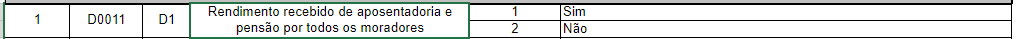

In [57]:
df_d0011 = selectByVarCode('D0011')
summary(df_d0011)


+-------------+------+
   Answers: 381438
+-------------+------+
  
+------+------+
|answer| count|
+------+------+
|   Não|250123|
|   Sim|131315|
+------+------+

+---+-----+---------+-----+
| UF|total|positives|  (%)|
+---+-----+---------+-----+
| 43|21931|     9710|44.28|
| 42|23432|     9780|41.74|
| 33|29065|    11335| 39.0|
| 24| 7775|     2952|37.97|
| 31|34339|    12918|37.62|
| 35|32104|    11774|36.67|
| 41|19872|     7243|36.45|
| 22| 8480|     3081|36.33|
| 23|16182|     5810| 35.9|
| 25| 9873|     3414|34.58|
| 27|11403|     3852|33.78|
| 53| 6795|     2249| 33.1|
| 29|17063|     5576|32.68|
| 21|20404|     6632| 32.5|
| 32|15863|     5066|31.94|
| 11| 6001|     1904|31.73|
| 28| 8013|     2486|31.02|
| 26|17138|     5263|30.71|
| 12| 6102|     1833|30.04|
| 17| 5087|     1518|29.84|
| 52|14195|     4202| 29.6|
| 50| 8657|     2492|28.79|
| 51|11359|     3032|26.69|
| 15|11878|     3019|25.42|
| 13|10341|     2558|24.74|
| 14| 5614|     1175|20.93|
| 16| 2472|      441|1

## D1.D0021 - Rendimento de pensão alimentícia, doação ou mesada em dinheiro de pessoa que não morava no domicílio

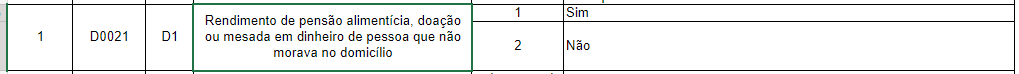

In [58]:
df_d0021 = selectByVarCode('D0021')
summary(df_d0021)


+-------------+------+
   Answers: 381438
+-------------+------+
  
+------+------+
|answer| count|
+------+------+
|   Não|362391|
|   Sim| 19047|
+------+------+

+---+-----+---------+-----+
| UF|total|positives|  (%)|
+---+-----+---------+-----+
| 28| 8013|      845|10.55|
| 16| 2472|      160| 6.47|
| 53| 6795|      416| 6.12|
| 50| 8657|      522| 6.03|
| 52|14195|      841| 5.92|
| 29|17063|     1001| 5.87|
| 24| 7775|      454| 5.84|
| 43|21931|     1243| 5.67|
| 12| 6102|      330| 5.41|
| 17| 5087|      275| 5.41|
| 51|11359|      610| 5.37|
| 35|32104|     1700|  5.3|
| 31|34339|     1718|  5.0|
| 11| 6001|      296| 4.93|
| 41|19872|      966| 4.86|
| 26|17138|      831| 4.85|
| 14| 5614|      271| 4.83|
| 25| 9873|      472| 4.78|
| 22| 8480|      396| 4.67|
| 23|16182|      745|  4.6|
| 32|15863|      698|  4.4|
| 33|29065|     1236| 4.25|
| 27|11403|      473| 4.15|
| 42|23432|      972| 4.15|
| 21|20404|      770| 3.77|
| 15|11878|      433| 3.65|
| 13|10341|      373| 

## D1.D0031 - Rendimentos de Programa Bolsa Família

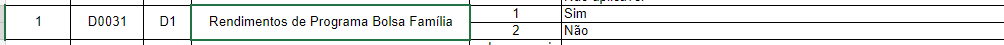

In [59]:
df_d0031 = selectByVarCode('D0031')
summary(df_d0031)


+-------------+------+
   Answers: 381438
+-------------+------+
  
+------+------+
|answer| count|
+------+------+
|   Não|344706|
|   Sim| 36732|
+------+------+

+---+-----+---------+-----+
| UF|total|positives|  (%)|
+---+-----+---------+-----+
| 21|20404|     4872|23.88|
| 29|17063|     3928|23.02|
| 28| 8013|     1831|22.85|
| 25| 9873|     2172| 22.0|
| 27|11403|     2258| 19.8|
| 26|17138|     2998|17.49|
| 12| 6102|      993|16.27|
| 23|16182|     2235|13.81|
| 15|11878|     1588|13.37|
| 13|10341|     1318|12.75|
| 22| 8480|      960|11.32|
| 14| 5614|      618|11.01|
| 24| 7775|      848|10.91|
| 17| 5087|      387| 7.61|
| 11| 6001|      395| 6.58|
| 31|34339|     2090| 6.09|
| 51|11359|      639| 5.63|
| 33|29065|     1602| 5.51|
| 52|14195|      626| 4.41|
| 41|19872|      818| 4.12|
| 50| 8657|      351| 4.05|
| 32|15863|      629| 3.97|
| 53| 6795|      265|  3.9|
| 35|32104|     1222| 3.81|
| 43|21931|      602| 2.74|
| 16| 2472|       60| 2.43|
| 42|23432|      427| 

## D1.D0041 -  No mês de ... _(mês de referência)_, ... recebeu rendimentos de Benefício Assistencial de Prestação Continuada – BPC-LOAS?

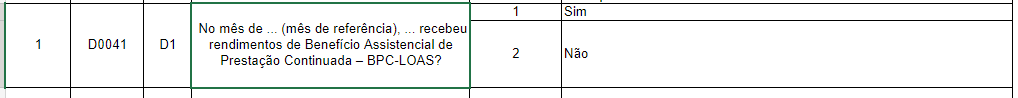

In [60]:
df_d0041 = selectByVarCode('D0041')
summary(df_d0041)


+-------------+------+
   Answers: 381438
+-------------+------+
  
+------+------+
|answer| count|
+------+------+
|   Não|367645|
|   Sim| 13793|
+------+------+

+---+-----+---------+----+
| UF|total|positives| (%)|
+---+-----+---------+----+
| 27|11403|      775| 6.8|
| 50| 8657|      541|6.25|
| 16| 2472|      148|5.99|
| 28| 8013|      465| 5.8|
| 25| 9873|      572|5.79|
| 13|10341|      580|5.61|
| 23|16182|      907| 5.6|
| 24| 7775|      428| 5.5|
| 15|11878|      599|5.04|
| 22| 8480|      422|4.98|
| 17| 5087|      240|4.72|
| 26|17138|      753|4.39|
| 29|17063|      682| 4.0|
| 12| 6102|      242|3.97|
| 31|34339|     1346|3.92|
| 21|20404|      797|3.91|
| 11| 6001|      234| 3.9|
| 51|11359|      411|3.62|
| 52|14195|      487|3.43|
| 53| 6795|      191|2.81|
| 32|15863|      359|2.26|
| 35|32104|      721|2.25|
| 43|21931|      437|1.99|
| 33|29065|      567|1.95|
| 14| 5614|      102|1.82|
| 41|19872|      361|1.82|
| 42|23432|      426|1.82|
+---+-----+---------+---

## D1.D0051 - Auxílios emergenciais relacionados ao coronavirus

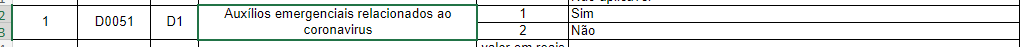

In [61]:
df_d0051 = selectByVarCode('D0051')
summary(df_d0051)


+-------------+------+
   Answers: 381438
+-------------+------+
  
+------+------+
|answer| count|
+------+------+
|   Não|196671|
|   Sim|184767|
+------+------+

+---+-----+---------+-----+
| UF|total|positives|  (%)|
+---+-----+---------+-----+
| 16| 2472|     1725|69.78|
| 27|11403|     7509|65.85|
| 21|20404|    13254|64.96|
| 15|11878|     7676|64.62|
| 29|17063|    10657|62.46|
| 22| 8480|     5279|62.25|
| 23|16182|    10051|62.11|
| 13|10341|     6407|61.96|
| 28| 8013|     4906|61.23|
| 26|17138|    10416|60.78|
| 12| 6102|     3635|59.57|
| 24| 7775|     4598|59.14|
| 25| 9873|     5835| 59.1|
| 14| 5614|     3000|53.44|
| 11| 6001|     3043|50.71|
| 17| 5087|     2575|50.62|
| 32|15863|     7535| 47.5|
| 52|14195|     6688|47.12|
| 31|34339|    15375|44.77|
| 51|11359|     5066| 44.6|
| 50| 8657|     3614|41.75|
| 33|29065|    11771| 40.5|
| 35|32104|    12000|37.38|
| 41|19872|     7276|36.61|
| 53| 6795|     2304|33.91|
| 43|21931|     6614|30.16|
| 42|23432|     5958|2

## D1.D0061 - Seguro desemprego

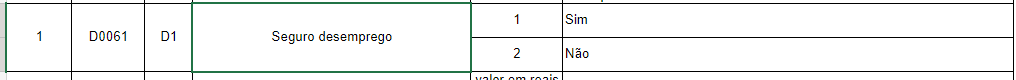

In [62]:
df_d0061 = selectByVarCode('D0061')
summary(df_d0061)


+-------------+------+
   Answers: 381438
+-------------+------+
  
+------+------+
|answer| count|
+------+------+
|   Não|376232|
|   Sim|  5206|
+------+------+

+---+-----+---------+----+
| UF|total|positives| (%)|
+---+-----+---------+----+
| 42|23432|      597|2.55|
| 35|32104|      689|2.15|
| 43|21931|      429|1.96|
| 53| 6795|      125|1.84|
| 51|11359|      191|1.68|
| 31|34339|      555|1.62|
| 32|15863|      251|1.58|
| 50| 8657|      123|1.42|
| 33|29065|      387|1.33|
| 52|14195|      187|1.32|
| 41|19872|      258| 1.3|
| 16| 2472|       32|1.29|
| 12| 6102|       77|1.26|
| 26|17138|      186|1.09|
| 28| 8013|       86|1.07|
| 11| 6001|       64|1.07|
| 25| 9873|      100|1.01|
| 29|17063|      167|0.98|
| 22| 8480|       80|0.94|
| 24| 7775|       71|0.91|
| 13|10341|       93| 0.9|
| 21|20404|      167|0.82|
| 23|16182|      128|0.79|
| 14| 5614|       35|0.62|
| 15|11878|       64|0.54|
| 27|11403|       47|0.41|
| 17| 5087|       17|0.33|
+---+-----+---------+---

## D1.D0071 - Outros rendimentos, como aluguel, arrendamento, previdência privada, bolsa de estudos, rendimentos de aplicação financeira etc.

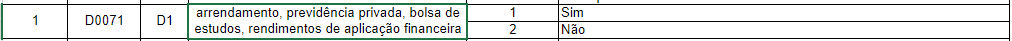

In [63]:
df_d0071 = selectByVarCode('D0071')
summary(df_d0071)


+-------------+------+
   Answers: 381438
+-------------+------+
  
+------+------+
|answer| count|
+------+------+
|   Não|362466|
|   Sim| 18972|
+------+------+

+---+-----+---------+----+
| UF|total|positives| (%)|
+---+-----+---------+----+
| 43|21931|     1831|8.35|
| 50| 8657|      668|7.72|
| 41|19872|     1424|7.17|
| 53| 6795|      470|6.92|
| 42|23432|     1620|6.91|
| 52|14195|      977|6.88|
| 35|32104|     2136|6.65|
| 51|11359|      701|6.17|
| 31|34339|     1878|5.47|
| 32|15863|      842|5.31|
| 24| 7775|      380|4.89|
| 33|29065|     1311|4.51|
| 11| 6001|      255|4.25|
| 17| 5087|      207|4.07|
| 25| 9873|      384|3.89|
| 15|11878|      458|3.86|
| 16| 2472|       91|3.68|
| 26|17138|      596|3.48|
| 23|16182|      533|3.29|
| 28| 8013|      259|3.23|
| 22| 8480|      272|3.21|
| 29|17063|      523|3.07|
| 12| 6102|      170|2.79|
| 14| 5614|      142|2.53|
| 27|11403|      287|2.52|
| 13|10341|      240|2.32|
| 21|20404|      317|1.55|
+---+-----+---------+---